### Подключение библиотек

In [71]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

### Подключение к GPU

In [73]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Загрузка датасета. Формат X и Y

In [74]:
# Чтение датасета из файла, зарегистрированного кинект
test_df = pd.read_csv("test_data.txt", sep='\t', comment='#', encoding='utf-8')
# Сдвиг значений из индекса на колонку вперед
test_df = test_df.shift(periods=1, axis="columns")
test_df['HumFlex-L'] = test_df.index
test_df.index=[_ for _ in range(85400) ]
# Готовый Датасет
test_df

,HumFlex-L,HumFlex-R,HumAdd-L,HumAdd-R,HumPron-L,HumPron-R,CubFlex-L,CubFlex-R,CubPron-L,CubPron-R,RadFlex-L,RadFlex-R,RadAdd-L,RadAdd-R
0,25.3891,9.27357,8.17163,8.20268,6.54854,31.5294,131.409,12.6733,25.9416,-72.2202,12.4294,-0.131512,-37.7395,1.51097
1,25.3891,9.27357,8.17163,8.20268,6.54854,31.5294,131.409,12.6733,25.9416,-72.2202,12.4294,-0.131512,-37.7395,1.51097
2,25.3868,9.27080,8.17124,8.20132,6.54858,31.5304,131.410,12.6754,25.9413,-72.2209,12.4288,-0.131742,-37.7401,1.51067
3,25.3868,9.27080,8.17124,8.20132,6.54858,31.5304,131.410,12.6754,25.9413,-72.2209,12.4288,-0.131742,-37.7401,1.51067
4,25.3844,9.26813,8.17081,8.19961,6.54859,31.5316,131.411,12.6767,25.9409,-72.2216,12.4281,-0.131909,-37.7408,1.51038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85395,26.4817,8.81054,10.46340,10.15400,13.71280,44.9465,149.520,44.0545,31.3010,-80.1557,10.8189,1.841450,-51.1252,1.24794
85396,26.4827,8.81207,10.46390,10.15460,13.71320,44.9472,149.519,44.0548,31.3012,-80.1564,10.8193,1.841770,-51.1252,1.24859
85397,26.4827,8.81207,10.46390,10.15460,13.71320,44.9472,149.519,44.0548,31.3012,-80.1564,10.8193,1.841770,-51.1252,1.24859
85398,26.4837,8.81374,10.46450,10.15540,13.71340,44.9475,149.519,44.0552,31.3014,-80.1570,10.8199,1.841800,-51.1252,1.24873


In [75]:
# Перемещение 4х прогнозируемых колонок вперед (локтевой сустав)
# Обозначения:
# L / R - левая и правая рука
# CubFlex / CubPron- локтевое сгибание / пронация
# HumFlex / HumPron / HumAdd - плечевое сгибание / пронация / приведение
# RadFlex / RadAdd - лучезапястное сгибание / приведение
tmp_test_df = pd.DataFrame({
                            'CubFlex-L': test_df['CubFlex-L'], 'CubFlex-R': test_df['CubFlex-R'],
                            'CubPron-L': test_df['CubPron-L'], 'CubPron-R': test_df['CubPron-R'],
                            'HumFlex-L': test_df['HumFlex-L'], 'HumFlex-R': test_df['HumFlex-R'],
                            'HumPron-L': test_df['HumPron-L'], 'HumPron-R': test_df['HumPron-R'],
                            'HumAdd-L': test_df['HumAdd-L'], 'HumAdd-R': test_df['HumAdd-R'],
                            'RadFlex-L': test_df['RadFlex-L'], 'RadFlex-R': test_df['RadFlex-R'],
                            'RadAdd-L': test_df['RadAdd-L'], 'RadAdd-R': test_df['RadAdd-R'],
                             })

output_df = tmp_test_df.loc[:, 'CubFlex-L' : 'CubPron-R']
input_df = tmp_test_df.loc[:, 'HumFlex-L' : 'RadAdd-R']
tmp_test_df

,CubFlex-L,CubFlex-R,CubPron-L,CubPron-R,HumFlex-L,HumFlex-R,HumPron-L,HumPron-R,HumAdd-L,HumAdd-R,RadFlex-L,RadFlex-R,RadAdd-L,RadAdd-R
0,131.409,12.6733,25.9416,-72.2202,25.3891,9.27357,6.54854,31.5294,8.17163,8.20268,12.4294,-0.131512,-37.7395,1.51097
1,131.409,12.6733,25.9416,-72.2202,25.3891,9.27357,6.54854,31.5294,8.17163,8.20268,12.4294,-0.131512,-37.7395,1.51097
2,131.410,12.6754,25.9413,-72.2209,25.3868,9.27080,6.54858,31.5304,8.17124,8.20132,12.4288,-0.131742,-37.7401,1.51067
3,131.410,12.6754,25.9413,-72.2209,25.3868,9.27080,6.54858,31.5304,8.17124,8.20132,12.4288,-0.131742,-37.7401,1.51067
4,131.411,12.6767,25.9409,-72.2216,25.3844,9.26813,6.54859,31.5316,8.17081,8.19961,12.4281,-0.131909,-37.7408,1.51038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85395,149.520,44.0545,31.3010,-80.1557,26.4817,8.81054,13.71280,44.9465,10.46340,10.15400,10.8189,1.841450,-51.1252,1.24794
85396,149.519,44.0548,31.3012,-80.1564,26.4827,8.81207,13.71320,44.9472,10.46390,10.15460,10.8193,1.841770,-51.1252,1.24859
85397,149.519,44.0548,31.3012,-80.1564,26.4827,8.81207,13.71320,44.9472,10.46390,10.15460,10.8193,1.841770,-51.1252,1.24859
85398,149.519,44.0552,31.3014,-80.1570,26.4837,8.81374,13.71340,44.9475,10.46450,10.15540,10.8199,1.841800,-51.1252,1.24873


In [76]:
WINDOW_SIZE = 20
# Структура входных и выходных данных (для window_size=20)
# 0, 1, ... - индекс строки в df
# [0:3] - Срез по индексам прогнозируемых колонок
#        X - входные данные        |   y  - выходные данные             
# [                                | [
#   [[0], [1], [2], ..., [19]],    |  [20[0:3]]
#   [[1], [2], [3], ..., [20]],    |  [21[0:3]]
#   [[2], [3], [4], ..., [21]],    |  [22[0:3]]
#   ...                            |  ...
#   [[85379],[85380],...,[85398]], |  [85399[0:3]]
# ]                                | ]

def df_to_X(df, window_size = WINDOW_SIZE):
  df_as_np = df.to_numpy()
  X = []
  for i in range(len(df_as_np)-window_size):
    row = np.array([r for r in df_as_np[i:i+window_size]])

    if np.isnan(row).any():
      print(row)
      continue
    X.append(row)
  return np.array(X)

def df_to_y(df, window_size = WINDOW_SIZE):
  df_as_np = df.to_numpy()
  y = []
  for i in range(len(df_as_np)-window_size):
    label = []
    for j in range(len(output_df.axes[1])):
      label.append(df_as_np[i+window_size][j])
    y.append(label)
  return np.array(y)

In [77]:
X, y = df_to_X(tmp_test_df), df_to_y(output_df)
X.shape, y.shape

((85380, 20, 14), (85380, 4))

### Разбиение на training, validation and test dataset

In [78]:
def splitToTrainValTest(X, y):
    X_train, y_train = X[:55000], y[:55000] # Было :60-60:70-70: стало 80%()
    X_val, y_val = X[55000:75000], y[55000:75000]
    X_test, y_test = X[75000:], y[75000:]
    print("Train:\n\t{}\n\t{}\nValidation:\n\t{}\n\t{}\nTest:\n\t{}\n\t{}".format(X_train.shape,  y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))
    return X_train, y_train, X_val, y_val, X_test, y_test

In [79]:
X_train, y_train, X_val, y_val, X_test, y_test = splitToTrainValTest(X, y)

Train:
	(55000, 20, 14)
	(55000, 4)
Validation:
	(20000, 20, 14)
	(20000, 4)
Test:
	(10380, 20, 14)
	(10380, 4)


### Отображение графиков результатов и расчет RMSE

In [95]:
def plot_predictions(predictions, actuals_y, start, end, isNormalized=False):
  CubFlexL_preds, CubFlexR_preds, CubPronL_preds, CubPronR_preds = predictions[:, 0], predictions[:, 1], predictions[:, 2], predictions[:, 3]
  CubFlexL_actuals, CubFlexR_actuals, CubPronL_actuals, CubPronR_actuals = actuals_y[:, 0], actuals_y[:, 1], actuals_y[:, 2], actuals_y[:, 3],
  df = pd.DataFrame(data={'CubFlex-L Predictions': CubFlexL_preds,
                          'CubFlex-L Actuals':CubFlexL_actuals,
                          'CubFlex-R Predictions': CubFlexR_preds,
                          'CubFlex-R Actuals':CubFlexR_actuals,
                          'CubPron-L Predictions': CubPronL_preds,
                          'CubPron-L Actuals':CubPronL_actuals,
                          'CubPron-R Predictions': CubPronR_preds,
                          'CubPron-R Actuals':CubPronR_actuals,
                          })
  fig = plt.figure(figsize=[12, 7])
  plt.subplot(2, 2, 1)
  plt.grid()
  plt.title('Локтевое сгибание-L')
  plt.xlabel('№ временного шага')
  if (isNormalized):
    plt.ylabel('normalized_angle')
  else:
    plt.ylabel('Суставной угол в градусах')
  l1 = plt.plot(df['CubFlex-L Predictions'][start:end], 'r--')
  l2 = plt.plot(df['CubFlex-L Actuals'][start:end], 'green')

  plt.subplot(2, 2, 2)
  plt.grid()

  plt.title('Локтевое сгибание-R')
  plt.xlabel('№ временного шага')
  if (isNormalized):
    plt.ylabel('normalized_angle')
  else:
    plt.ylabel('Суставной угол в градусах')
  plt.plot(df['CubFlex-R Predictions'][start:end], 'r--')
  plt.plot(df['CubFlex-R Actuals'][start:end], 'green')
  
  plt.subplot(2, 2, 3)
  plt.grid()
  plt.title('Локтевая пронация-L')
  plt.xlabel('№ временного шага')
  if (isNormalized):
    plt.ylabel('normalized_angle')
  else:
    plt.ylabel('Суставной угол в градусах')
  plt.plot(df['CubPron-L Predictions'][start:end], 'r--')
  plt.plot(df['CubPron-L Actuals'][start:end], 'green')

  plt.subplot(2, 2, 4)
  plt.grid()
  plt.title('Локтевая пронация-R')
  plt.xlabel('№ временного шага')
  if (isNormalized):
    plt.ylabel('normalized_angle')
  else:
    plt.ylabel('Суставной угол в градусах')
  plt.plot(df['CubPron-R Predictions'][start:end], 'r--',)
  plt.plot(df['CubPron-R Actuals'][start:end], 'green')

  plt.subplots_adjust( hspace=0.4)
  fig.legend([l1, l2], labels=['Прогнозируемые значения', 'Истинные значения'], loc="center")
  
  return df

In [82]:
def rmse(predictions, actuals):
    return np.sqrt(((predictions - actuals) ** 2).mean())

### Объявление функции Predict по нормализованным X_test

In [83]:
def get_normalized_predictions(model, X_normalized):
    normalized_predictions = model.predict(X_normalized)
    return normalized_predictions

### Нормализация MinMaxScaler

In [84]:
from sklearn.preprocessing import MinMaxScaler

In [85]:
class MinMaxScaler3D(MinMaxScaler):

    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

In [86]:
scaler_X_train = MinMaxScaler3D()
min_max_normalized_X_train = scaler_X_train.fit_transform(X_train)

min_max_normalized_X_test = scaler_X_train.fit_transform(X_test) 

min_max_normalized_X_val = scaler_X_train.fit_transform(X_val)



scaler_y_train = MinMaxScaler()
min_max_normalized_y_train = scaler_y_train.fit_transform(y_train)

min_max_normalized_y_test = scaler_y_train.fit_transform(y_test)

min_max_normalized_y_val = scaler_y_train.fit_transform(y_val)

### Модель 7 (обучена на новом скейлере)

In [16]:
model_7 = Sequential() # создаёт последовательную модель с пошаговым добавлением слоёв в неё
model_7.add(InputLayer((WINDOW_SIZE, 14)))
model_7.add(LSTM(128))
model_7.add(Dropout(0.5)) # помогает избавиться от переобучения модели.
# Таким образом, некоторые нейроны становятся равными 0, и это сокращает вычисления в процессе обучения.

# Dense - является самым необходимым и базовым.
# отвечает за соединение нейронов из предыдущего и следующего слоя.
# Например, если первый слой имеет 5 нейронов, а второй 3, то общее количество соединений между слоями будет равно 15.
# отвечает за эти соединения, и у него есть настраиваемые гиперпараметры: количество нейронов, тип активации, инициализация типа ядра.
model_7.add(Dense(16, 'relu'))
model_7.add(Dense(4, 'linear'))

model_7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               73216     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 75,348
Trainable params: 75,348
Non-trainable params: 0
_________________________________________________________________


In [18]:
cp_7_epochs = ModelCheckpoint('model_7_epochs/{epoch:02d}-{val_loss:.4f}', save_best_only=True)
model_7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [19]:
history_object_7_epochs = model_7.fit(min_max_normalized_X_train, min_max_normalized_y_train, validation_data=(min_max_normalized_X_val, min_max_normalized_y_val), epochs=80, callbacks=[cp_7_epochs], batch_size=32)

Epoch 1/80
1717/1719 [============================>.] - ETA: 0s - loss: 0.0192 - root_mean_squared_error: 0.1385

INFO:tensorflow:Assets written to: model_7_epochs\01-0.0048\assets


INFO:tensorflow:Assets written to: model_7_epochs\01-0.0048\assets


1719/1719 [==============================] - 43s 16ms/step - loss: 0.0192 - root_mean_squared_error: 0.1384 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0693
Epoch 2/80
1719/1719 [==============================] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0763

INFO:tensorflow:Assets written to: model_7_epochs\02-0.0034\assets


INFO:tensorflow:Assets written to: model_7_epochs\02-0.0034\assets


1719/1719 [==============================] - 29s 17ms/step - loss: 0.0058 - root_mean_squared_error: 0.0763 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0585
Epoch 3/80
1715/1719 [============================>.] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0621

INFO:tensorflow:Assets written to: model_7_epochs\03-0.0028\assets


INFO:tensorflow:Assets written to: model_7_epochs\03-0.0028\assets


1719/1719 [==============================] - 26s 15ms/step - loss: 0.0039 - root_mean_squared_error: 0.0621 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 4/80
1716/1719 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0511

INFO:tensorflow:Assets written to: model_7_epochs\04-0.0027\assets


INFO:tensorflow:Assets written to: model_7_epochs\04-0.0027\assets


1719/1719 [==============================] - 25s 14ms/step - loss: 0.0026 - root_mean_squared_error: 0.0511 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521
Epoch 5/80
1715/1719 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0420

INFO:tensorflow:Assets written to: model_7_epochs\05-0.0027\assets


INFO:tensorflow:Assets written to: model_7_epochs\05-0.0027\assets


1719/1719 [==============================] - 24s 14ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0519
Epoch 6/80
1719/1719 [==============================] - 20s 11ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0531
Epoch 7/80
1719/1719 [==============================] - 19s 11ms/step - loss: 9.9617e-04 - root_mean_squared_error: 0.0316 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 8/80
1719/1719 [==============================] - ETA: 0s - loss: 8.7423e-04 - root_mean_squared_error: 0.0296

INFO:tensorflow:Assets written to: model_7_epochs\08-0.0026\assets


INFO:tensorflow:Assets written to: model_7_epochs\08-0.0026\assets


1719/1719 [==============================] - 25s 14ms/step - loss: 8.7423e-04 - root_mean_squared_error: 0.0296 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0505
Epoch 9/80
1717/1719 [============================>.] - ETA: 0s - loss: 8.0932e-04 - root_mean_squared_error: 0.0284

INFO:tensorflow:Assets written to: model_7_epochs\09-0.0025\assets


INFO:tensorflow:Assets written to: model_7_epochs\09-0.0025\assets


1719/1719 [==============================] - 25s 14ms/step - loss: 8.0927e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0500
Epoch 10/80
1719/1719 [==============================] - ETA: 0s - loss: 7.6579e-04 - root_mean_squared_error: 0.0277

INFO:tensorflow:Assets written to: model_7_epochs\10-0.0024\assets


INFO:tensorflow:Assets written to: model_7_epochs\10-0.0024\assets


1719/1719 [==============================] - 24s 14ms/step - loss: 7.6579e-04 - root_mean_squared_error: 0.0277 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487
Epoch 11/80
1717/1719 [============================>.] - ETA: 0s - loss: 7.3835e-04 - root_mean_squared_error: 0.0272

INFO:tensorflow:Assets written to: model_7_epochs\11-0.0021\assets


INFO:tensorflow:Assets written to: model_7_epochs\11-0.0021\assets


1719/1719 [==============================] - 25s 15ms/step - loss: 7.3840e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 12/80
1719/1719 [==============================] - 20s 12ms/step - loss: 7.1168e-04 - root_mean_squared_error: 0.0267 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0469
Epoch 13/80
1719/1719 [==============================] - 20s 12ms/step - loss: 6.9100e-04 - root_mean_squared_error: 0.0263 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 14/80
1716/1719 [============================>.] - ETA: 0s - loss: 6.6511e-04 - root_mean_squared_error: 0.0258

INFO:tensorflow:Assets written to: model_7_epochs\14-0.0020\assets


INFO:tensorflow:Assets written to: model_7_epochs\14-0.0020\assets


1719/1719 [==============================] - 24s 14ms/step - loss: 6.6487e-04 - root_mean_squared_error: 0.0258 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 15/80
1719/1719 [==============================] - 20s 12ms/step - loss: 6.5282e-04 - root_mean_squared_error: 0.0256 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 16/80
1719/1719 [==============================] - ETA: 0s - loss: 6.3457e-04 - root_mean_squared_error: 0.0252

INFO:tensorflow:Assets written to: model_7_epochs\16-0.0019\assets


INFO:tensorflow:Assets written to: model_7_epochs\16-0.0019\assets


1719/1719 [==============================] - 24s 14ms/step - loss: 6.3457e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 17/80
1718/1719 [============================>.] - ETA: 0s - loss: 6.2721e-04 - root_mean_squared_error: 0.0250

INFO:tensorflow:Assets written to: model_7_epochs\17-0.0017\assets


INFO:tensorflow:Assets written to: model_7_epochs\17-0.0017\assets


1719/1719 [==============================] - 28s 16ms/step - loss: 6.2717e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 18/80
1719/1719 [==============================] - 19s 11ms/step - loss: 6.1350e-04 - root_mean_squared_error: 0.0248 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 19/80
1719/1719 [==============================] - 23s 13ms/step - loss: 5.9719e-04 - root_mean_squared_error: 0.0244 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443
Epoch 20/80
1719/1719 [==============================] - 22s 13ms/step - loss: 5.8503e-04 - root_mean_squared_error: 0.0242 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 21/80
1719/1719 [==============================] - 23s 13ms/step - loss: 5.7597e-04 - root_mean_squared_error: 0.0240 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0415
Epoch 22/80
1719/1719 [==============================] - 22s 13ms/step - loss: 5.6761e-04 - root_mean_squar

INFO:tensorflow:Assets written to: model_7_epochs\24-0.0016\assets


INFO:tensorflow:Assets written to: model_7_epochs\24-0.0016\assets


1719/1719 [==============================] - 30s 18ms/step - loss: 5.4504e-04 - root_mean_squared_error: 0.0233 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 25/80
1719/1719 [==============================] - 22s 13ms/step - loss: 5.3341e-04 - root_mean_squared_error: 0.0231 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 26/80
1719/1719 [==============================] - 24s 14ms/step - loss: 5.2470e-04 - root_mean_squared_error: 0.0229 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 27/80
1719/1719 [==============================] - 22s 13ms/step - loss: 5.1506e-04 - root_mean_squared_error: 0.0227 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 28/80
1719/1719 [==============================] - 25s 15ms/step - loss: 5.0860e-04 - root_mean_squared_error: 0.0226 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0411
Epoch 29/80
1718/1719 [============================>.] - ETA: 0s - loss: 4.9827e-04 - root_mean_squared_err

INFO:tensorflow:Assets written to: model_7_epochs\29-0.0016\assets


INFO:tensorflow:Assets written to: model_7_epochs\29-0.0016\assets


1719/1719 [==============================] - 36s 21ms/step - loss: 4.9828e-04 - root_mean_squared_error: 0.0223 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 30/80
1719/1719 [==============================] - 23s 14ms/step - loss: 4.9419e-04 - root_mean_squared_error: 0.0222 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 31/80
1719/1719 [==============================] - 22s 13ms/step - loss: 4.8679e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 32/80
1718/1719 [============================>.] - ETA: 0s - loss: 4.7915e-04 - root_mean_squared_error: 0.0219

INFO:tensorflow:Assets written to: model_7_epochs\32-0.0015\assets


INFO:tensorflow:Assets written to: model_7_epochs\32-0.0015\assets


1719/1719 [==============================] - 29s 17ms/step - loss: 4.7918e-04 - root_mean_squared_error: 0.0219 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 33/80
1716/1719 [============================>.] - ETA: 0s - loss: 4.6497e-04 - root_mean_squared_error: 0.0216

INFO:tensorflow:Assets written to: model_7_epochs\33-0.0015\assets


INFO:tensorflow:Assets written to: model_7_epochs\33-0.0015\assets


1719/1719 [==============================] - 30s 17ms/step - loss: 4.6486e-04 - root_mean_squared_error: 0.0216 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 34/80
1715/1719 [============================>.] - ETA: 0s - loss: 4.6314e-04 - root_mean_squared_error: 0.0215

INFO:tensorflow:Assets written to: model_7_epochs\34-0.0015\assets


INFO:tensorflow:Assets written to: model_7_epochs\34-0.0015\assets


1719/1719 [==============================] - 34s 20ms/step - loss: 4.6338e-04 - root_mean_squared_error: 0.0215 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 35/80
1719/1719 [==============================] - 24s 14ms/step - loss: 4.5551e-04 - root_mean_squared_error: 0.0213 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 36/80
1719/1719 [==============================] - ETA: 0s - loss: 4.4525e-04 - root_mean_squared_error: 0.0211

INFO:tensorflow:Assets written to: model_7_epochs\36-0.0014\assets


INFO:tensorflow:Assets written to: model_7_epochs\36-0.0014\assets


1719/1719 [==============================] - 32s 19ms/step - loss: 4.4525e-04 - root_mean_squared_error: 0.0211 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 37/80
1719/1719 [==============================] - 23s 14ms/step - loss: 4.4479e-04 - root_mean_squared_error: 0.0211 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 38/80
1719/1719 [==============================] - 25s 15ms/step - loss: 4.3368e-04 - root_mean_squared_error: 0.0208 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 39/80
1719/1719 [==============================] - 25s 14ms/step - loss: 4.3230e-04 - root_mean_squared_error: 0.0208 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 40/80
1719/1719 [==============================] - 29s 17ms/step - loss: 4.2566e-04 - root_mean_squared_error: 0.0206 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 41/80
1719/1719 [==============================] - 31s 18ms/step - loss: 4.2258e-04 - root_mean_squar

INFO:tensorflow:Assets written to: model_7_epochs\42-0.0014\assets


INFO:tensorflow:Assets written to: model_7_epochs\42-0.0014\assets


1719/1719 [==============================] - 33s 19ms/step - loss: 4.1370e-04 - root_mean_squared_error: 0.0203 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 43/80
1719/1719 [==============================] - 30s 18ms/step - loss: 4.0694e-04 - root_mean_squared_error: 0.0202 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 44/80
1719/1719 [==============================] - 29s 17ms/step - loss: 4.0528e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0378
Epoch 45/80
1719/1719 [==============================] - 32s 19ms/step - loss: 4.0259e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0411
Epoch 46/80
1719/1719 [==============================] - 37s 21ms/step - loss: 3.9736e-04 - root_mean_squared_error: 0.0199 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 47/80
1719/1719 [==============================] - 31s 18ms/step - loss: 3.9249e-04 - root_mean_squar

### Сохранение History Object после обучения

In [20]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history_object_7_epochs.history)  

# save to csv: 
hist_csv_file = 'history_7_epochs.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Загрузка loaded_hist_df обученной 7 модели

In [97]:
loaded_hist_df = pd.read_csv("history_7_epochs.csv")
loaded_hist_df = loaded_hist_df.rename(columns={
    'Unnamed: 0' : '№ эпохи',
    'loss' : 'Train Loss',
    'root_mean_squared_error' : 'Train RMSE',
    'val_loss' : 'Val Loss',
    'val_root_mean_squared_error' : 'Val RMSE'
})
loaded_hist_df

,№ эпохи,Train Loss,Train RMSE,Val Loss,Val RMSE
0,0,0.019159,0.138417,0.004806,0.069326
1,1,0.005818,0.076276,0.003425,0.058522
2,2,0.003854,0.062079,0.002767,0.052600
3,3,0.002616,0.051143,0.002712,0.052081
4,4,0.001763,0.041991,0.002697,0.051937
...,...,...,...,...,...
75,75,0.000302,0.017373,0.002003,0.044757
76,76,0.000298,0.017260,0.001957,0.044235
77,77,0.000294,0.017157,0.002060,0.045390
78,78,0.000293,0.017126,0.002151,0.046382


### Загрузка 7_epochs модели (для Графиков прогнозов / реальных данных)
##### *Графики ошибок строятся по History Object

In [88]:
refresh_model_7_epochs = tf.keras.models.load_model('model_7_epochs/42-0.0014')
refresh_model_7_epochs.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               73216     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 75,348
Trainable params: 75,348
Non-trainable params: 0
_________________________________________________________________


### Диаграмма обученной модели

In [20]:
import keras.utils.vis_utils
from tensorflow.keras.utils import plot_model
from importlib import reload
reload(keras.utils.vis_utils)

<module 'keras.utils.vis_utils' from 'd:\\miniconda3\\envs\\tf\\lib\\site-packages\\keras\\utils\\vis_utils.py'>

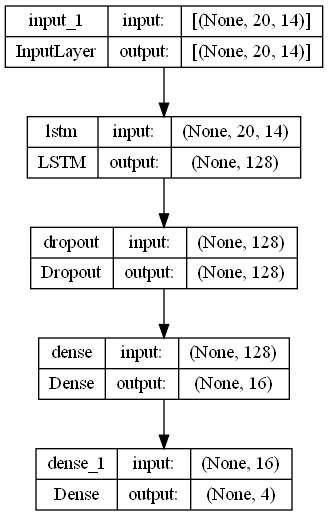

In [52]:
plot_model(refresh_model_7_epochs, show_shapes=True, to_file='D:\PythonProjects\Diplom\diagrams\LSTM_MinMax_80_epochs.png')

### Predict по загруженной модели

In [91]:
normalized_predictions_7_epochs = get_normalized_predictions(refresh_model_7_epochs, min_max_normalized_X_test)

325/325 [==============================] - 10s 11ms/step


### Функция plot_errors() по загруженному History Object

In [98]:
def plot_errors_2(hist_df):
  fig = plt.figure(figsize=[8, 3])
  ax1 = plt.subplot(1, 2, 1)
  plt.grid()
  plt.title('Зависимость MSE от № эпохи')
  plt.xlabel('№ эпохи')
  plt.ylabel('Значение loss')
  ax1.set_ylim(0.000, 0.005)
  line2 = plt.plot(hist_df['Train Loss'], 'blue')
  line = plt.plot(hist_df['Val Loss'], 'green')
  plt.legend([line2, line], labels=['На тренировочных','На валидационных',], loc='upper right')

  ax2 = plt.subplot(1, 2, 2)
  plt.grid()

  plt.title('Значение RMSE в градусах - 4.03°')
  plt.xlabel('№ эпохи')
  plt.ylabel('Значение RMSE')
  plt.yticks([i*0.01 for i in range(7)])
  ax2.set_ylim(0.00, 0.062)
  plt.plot(hist_df['Train RMSE'], 'blue')
  plt.plot(hist_df['Val RMSE'], 'green')
  plt.legend([line2, line], labels=['На тренировочных','На валидационных',], loc='lower right')

  plt.subplots_adjust(wspace=0.4)

### Построение графика ошибок val_RMSE и val_loss 

C:\Users\660\AppData\Local\Temp\ipykernel_16276\2176664706.py:11: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([line2, line], labels=['На тренировочных','На валидационных',], loc='upper right')
C:\Users\660\AppData\Local\Temp\ipykernel_16276\2176664706.py:23: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([line2, line], labels=['На тренировочных','На валидационных',], loc='lower right')


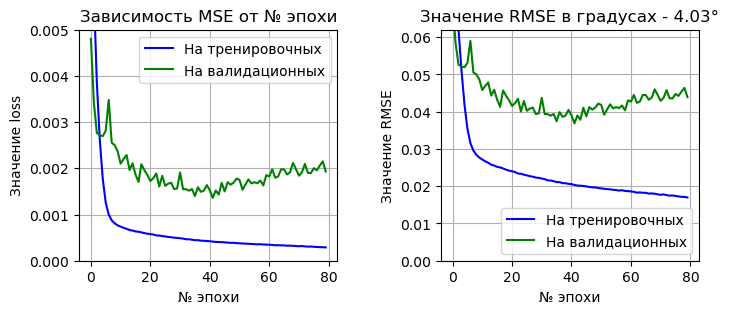

In [99]:
plot_errors_2(loaded_hist_df)

### График прогнозов по нормализованным данным

In [28]:
rmse(normalized_predictions_7_epochs, min_max_normalized_y_test)

0.05666839723549725

C:\Users\660\AppData\Local\Temp\ipykernel_16276\1194250980.py:60: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=['Прогнозируемые значения', 'Истинные значения'], loc="center")


,CubFlex-L Predictions,CubFlex-L Actuals,CubFlex-R Predictions,CubFlex-R Actuals,CubPron-L Predictions,CubPron-L Actuals,CubPron-R Predictions,CubPron-R Actuals
0,0.890078,0.967917,0.706607,0.900936,0.011896,0.000366,0.122276,0.002833
1,0.890103,0.967917,0.706407,0.900936,0.011820,0.000366,0.122289,0.002833
2,0.890148,0.968173,0.706257,0.900335,0.011754,0.000219,0.122261,0.002610
3,0.890179,0.968173,0.706068,0.900335,0.011694,0.000219,0.122260,0.002610
4,0.890228,0.968407,0.705924,0.899616,0.011646,0.000110,0.122220,0.002365
...,...,...,...,...,...,...,...,...
10375,0.971392,0.947466,0.880146,0.999761,0.422976,0.395604,0.258875,0.316080
10376,0.971446,0.947445,0.880170,0.999780,0.422995,0.395611,0.258862,0.315923
10377,0.971490,0.947445,0.880185,0.999780,0.423017,0.395611,0.258841,0.315923
10378,0.971544,0.947445,0.880213,0.999806,0.423035,0.395618,0.258811,0.315789


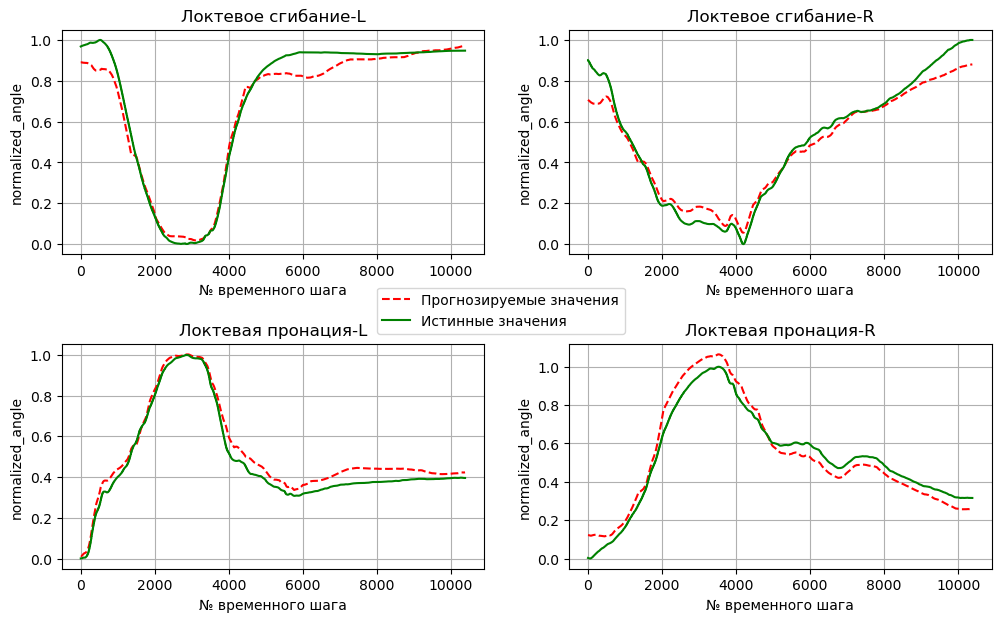

In [96]:
plot_predictions(normalized_predictions_7_epochs, min_max_normalized_y_test, 0, 11000, True)

### Результаты по восстановленным данным

In [32]:
postprocessed_predictions_7_epochs = scaler_y_train.inverse_transform(normalized_predictions_7_epochs)

In [ ]:
plot_predictions(postprocessed_predictions_7_epochs, y_test, 0, 11000)

In [34]:
rmse(postprocessed_predictions_7_epochs, y_test)

4.032496339742036